<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor(),])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 128 # 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader) # get some random training images
# images, labels = next(dataiter)
# print(images.shape) # [batch, 3, 32, 32]
# imshow(torchvision.utils.make_grid(images))


100%|██████████| 170M/170M [00:14<00:00, 12.2MB/s]


In [ ]:
# @title ViT me simple
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        self.lin = nn.Linear(d_model, d_model)
        # self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V

# https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py#L1855

class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_mult=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*ff_mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, ff_dim), act, # ReLU GELU
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Dropout(dropout), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        # bchw = x.shape
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm1(x)))
        if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(x))

        # return x.transpose(1,2).reshape(*bchw)
        return x


class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, dim, depth, heads, mlp_dim, channels=3, dim_head=8):
        super().__init__()
        self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
            nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(2,2)
            )
        # self.pos_embedding = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
        self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, dim)) # positional_embedding == 'learnable'
        self.transformer = AttentionBlock(d_model=dim, d_head=dim_head)
        # self.transformer_blocks = nn.ModuleList([AttentionBlock(d_model=dim, d_head=dim_head) for i in range(depth)])

        self.attention_pool = nn.Linear(dim, 1)
        self.out = nn.Linear(dim, out_dim, bias=False)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        # x = self.pos_embedding(x)
        x = x.flatten(-2).transpose(-2,-1) # b c h w -> b (h w) c
        x = x + self.positional_emb
        x = self.transformer(x)
        # for blk in self.predictor_blocks: x = blk(x)

        # x = x.flatten(-2).mean(dim=-1) # mean pool
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]
        # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
        # x = torch.cat((cls_token, x), dim=1)
        # x = x[:, 0] # first token
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# dim = 64
# dim_head = 8
# heads = dim // dim_head
# num_classes = 10
# # model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# model = SimpleViT(in_dim=3, out_dim=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
# optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# # print(images.shape) # [batch, 3, 32, 32]
# x = torch.rand(64, 3, 32, 32, device=device)
# # x = torch.rand(64, 3, 28,28, device=device)
# logits = model(x)
# print(logits.shape)
# pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# # print(y_pred)


In [ ]:
# @title efficientvit nn/ops.py down
# https://github.com/mit-han-lab/efficientvit/blob/master/efficientvit/models/nn/ops.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SameCh(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # print('samech', in_ch, out_ch, in_ch//out_ch, out_ch//in_ch)
        # if out_ch//in_ch > 1: self.func = lambda x: x.repeat_interleave(out_ch//in_ch, dim=1) # [b,i,h,w] -> [b,o,h,w]
        # elif in_ch//out_ch > 1:
        #     self.func = lambda x: torch.unflatten(x, 1, (out_ch, in_ch//out_ch)).mean(dim=2) # [b,i,h,w] -> [b,o,i/o,h,w] -> [b,o,h,w]
        # elif in_ch==out_ch: self.func = lambda x: x
        if in_ch>=out_ch: # ave
            # self.func = lambda x: F.interpolate(x.flatten(2).transpose(1,2), size=out_ch, mode='nearest-exact').transpose(1,2).unflatten(-1,(x.shape[-2:])) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
            self.func = lambda x: F.adaptive_avg_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
            # self.func = lambda x: F.adaptive_max_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        elif in_ch<out_ch: # nearest
            self.func = lambda x: F.interpolate(x.flatten(2).transpose(1,2), size=out_ch, mode='nearest-exact').transpose(1,2).unflatten(-1,(x.shape[-2:])) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
            # self.func = lambda x: F.adaptive_avg_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
            # self.func = lambda x: F.adaptive_max_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        # else:
        #     print('SameCh err', in_ch, out_ch)
    def forward(self, x): return self.func(x) # [b,c,h,w] -> [b,o,h,w]

class SameCh(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        if in_ch >= out_ch: self.func = lambda x: F.adaptive_avg_pool1d(x.flatten(2).transpose(1,2), out_ch).transpose(1,2).unflatten(-1,(x.shape[-2:])) # https://pytorch.org/docs/stable/nn.html#pooling-layers
        elif in_ch < out_ch: self.func = lambda x: F.interpolate(x.flatten(2).transpose(1,2), size=out_ch, mode='nearest-exact').transpose(1,2).unflatten(-1,(x.shape[-2:])) # pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
    def forward(self, x): return self.func(x) # [b,c,h,w] -> [b,o,h,w]

class PixelShortcut(nn.Module):
    def __init__(self, in_ch, out_ch, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(SameCh(in_ch, out_ch*r**2), nn.PixelShuffle(r)) #
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), SameCh(in_ch*r**2, out_ch)) #
        else: self.net = SameCh(in_ch, out_ch)
    def forward(self, x): return self.net(x) # [b,c,h,w] -> [b,o,r*h,r*w]

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch=None, kernel=3, r=1):
        super().__init__()
        self.r = r
        r = max(r, int(1/r))
        out_ch = out_ch or in_ch
        # if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        if self.r>1: self.net = nn.Sequential(SeparableConv2d(in_ch, out_ch), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), SeparableConv2d(in_ch, out_ch)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2, bias=False)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # elif self.r<1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch//r**2, kernel, 1, kernel//2, bias=False), nn.PixelUnshuffle(r)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]

        # if self.r>1: self.net = nn.Sequential(init_conv(nn.Conv2d(in_ch, out_ch*r**2, kernel, 1, kernel//2), out_r=r), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        # elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), init_conv(nn.Conv2d(in_ch*r**2, out_ch, kernel, 1, kernel//2), in_r=r)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        # else: self.net = nn.Conv2d(in_ch, out_ch, kernel, 1, kernel//2)
        else: self.net = SeparableConv2d(in_ch, out_ch)
        # self.net.apply(self.init_conv_)

    def forward(self, x):
        return self.net(x)


class UpDownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, r=1, kernel=3):
        super().__init__()
        self.block = PixelShuffleConv(in_ch, out_ch, kernel=kernel, r=r)
        self.shortcut_block = PixelShortcut(in_ch, out_ch, r=r)
    def forward(self, x):
        # print('UpDownBlock', x.shape, self.block(x).shape, self.shortcut_block(x).shape)
        return self.block(x) + self.shortcut_block(x)
        # return self.shortcut_block(x)

# model = UpDownBlock(3, 24, r=1/2)#.to(device)
# model = UpDownBlock(width_list[0], out_ch, r=2)

# x = torch.rand(64, 3, 32, 32, device=device)
x = torch.rand(2, 3, 32, 32)
# out = model(x)

# print(out.shape)


## out

In [ ]:
# @title pool tok mixer
# MetaFormer is Actually What You Need for Vision
# https://openaccess.thecvf.com/content/CVPR2022/papers/Yu_MetaFormer_Is_Actually_What_You_Need_for_Vision_CVPR_2022_paper.pdf

import torch.nn as nn
class Pooling(nn.Module):
    def __init__(self, pool_size=3):
        super().__init__()
        self.pool = nn.AvgPool2d(pool_size, stride=1, padding=pool_size//2, count_include_pad=False)
    def forward(self, x): # [b,c,h,w]
        return self.pool(x) - x # Subtraction of the input itself is added since the block already has a residual connection.

# model = Pooling()
# x = torch.randn(2, 3, 7,9)
# out = model(x)
# print(out.shape)


In [ ]:
# @title SeparableConv2d
# Xception: Deep Learning with Depthwise Separable Convolutions https://arxiv.org/pdf/1610.02357
class SeparableConv2d(nn.Module):
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        out_ch = out_ch or in_ch
        self.conv = nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1, bias=False)

    def forward(self,x):
        x = self.conv(x)
        x = self.pointwise(x)
        return x

class SeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        out_ch = out_ch or in_ch
        self.conv = nn.Convd(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False)
        self.pointwise = nn.Convd(in_ch, out_ch, 1, bias=False)

    def forward(self,x):
        x = self.conv(x)
        x = self.pointwise(x)
        return x

# #  'all Convolution and SeparableConvolution layers are followed by batch normalization'?
# in_ch, out_ch = 3, 3
# model = SeparableConv2d(in_ch, out_ch)
# x = torch.randn(2, in_ch, 7,9)
# out = model(x)
# print(out.shape)


In [ ]:
# @title UniversalInvertedBottleneckBlock
import torch
import torch.nn as nn
import torch.nn.functional as F

class UIB(nn.Module):
    def __init__(self, in_ch, out_ch=None, mult=4):
        super().__init__()
        act = nn.SiLU()
        out_ch = out_ch or in_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.BatchNorm2d(in_ch),
            nn.Conv2d(in_ch, mult*in_ch, 1, bias=False), nn.BatchNorm2d(mult*in_ch), act,
            nn.Conv2d(mult*in_ch, mult*in_ch, 3, 1, 3//2, groups=mult*in_ch, bias=False), nn.BatchNorm2d(mult*in_ch), act,
            nn.Conv2d(mult*in_ch, out_ch, 1, bias=False), nn.BatchNorm2d(out_ch),
        )
        self.gamma = nn.Parameter(1e-5 * torch.ones(out_ch, 1, 1))

    def forward(self,x):
        x = self.conv(x) * self.gamma
        return x

in_ch, out_ch = 3, 3
model = UIB(in_ch, out_ch)
x = torch.randn(2, in_ch, 7,9)
out = model(x)
print(out.shape)
# print(sum(p.numel() for p in model.conv[0].parameters() if p.requires_grad)) # 59850
print([p.numel() for p in model.conv.parameters() if p.requires_grad]) # 59850


torch.Size([2, 3, 7, 9])
[27, 3, 3, 36, 12, 12, 108, 12, 12, 36, 3, 3]


In [ ]:
# fused?
class UIB(nn.Module):
    def __init__(self, in_ch, out_ch=None, mult=4):
        super().__init__()
        act = nn.SiLU()
        out_ch = out_ch or in_ch
        self.conv = nn.Sequential( # og
            nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.BatchNorm2d(in_ch),
            nn.Conv2d(in_ch, mult*in_ch, 1, bias=False), nn.BatchNorm2d(mult*in_ch), act,
            nn.Conv2d(mult*in_ch, mult*in_ch, 3, 1, 3//2, groups=mult*in_ch, bias=False), nn.BatchNorm2d(mult*in_ch), act,
            nn.Conv2d(mult*in_ch, out_ch, 1, bias=False), nn.BatchNorm2d(out_ch),
        )
        self.conv = nn.Sequential( # og
            nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.Conv2d(in_ch, mult*in_ch, 1, bias=False),
            nn.BatchNorm2d(mult*in_ch), act,
            nn.Conv2d(mult*in_ch, mult*in_ch, 3, 1, 3//2, groups=mult*in_ch, bias=False), nn.Conv2d(mult*in_ch, out_ch, 1, bias=False), #nn.BatchNorm2d(mult*in_ch), act,
            nn.BatchNorm2d(out_ch),
        )
        # self.conv = nn.Sequential( # me
        #     nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.BatchNorm2d(in_ch),
        #     GatedAdaLN(in_ch), nn.BatchNorm2d(in_ch), act,
        #     nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.BatchNorm2d(in_ch), act,
        #     nn.Conv2d(in_ch, out_ch, 1, bias=False), nn.BatchNorm2d(out_ch),
        # )
        # self.conv = nn.Sequential( # fused
        #     nn.Conv2d(in_ch, mult*in_ch, 3, 1, 3//2, groups=in_ch, bias=False), nn.BatchNorm2d(mult*in_ch),
        #     # nn.Conv2d(in_ch, mult*in_ch, 1, bias=False), nn.BatchNorm2d(mult*in_ch), act,
        #     nn.Conv2d(mult*in_ch, mult*in_ch, 3, 1, 3//2, groups=mult*in_ch, bias=False), nn.BatchNorm2d(mult*in_ch), act,
        #     nn.Conv2d(mult*in_ch, out_ch, 1, bias=False), nn.BatchNorm2d(out_ch),
        # )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, mult*in_ch, 1, bias=False),
            nn.BatchNorm2d(mult*in_ch), act, nn.Conv2d(mult*in_ch, mult*in_ch, 3, 1, 3//2, groups=mult*in_ch, bias=False),
            nn.BatchNorm2d(mult*in_ch), act, zero_module(nn.Conv2d(mult*in_ch, out_ch, 1, bias=False)),
        )

        # self.conv = nn.Sequential(
        #     nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, mult*in_ch, 3, 1, 3//2, groups=in_ch, bias=False),
        #     # nn.Conv2d(in_ch, mult*in_ch, 1, bias=False), nn.BatchNorm2d(mult*in_ch), act,
        #     nn.Conv2d(mult*in_ch, mult*in_ch, 3, 1, 3//2, groups=mult*in_ch, bias=False), nn.BatchNorm2d(mult*in_ch), act,
        #     nn.Conv2d(mult*in_ch, out_ch, 1, bias=False), nn.BatchNorm2d(out_ch),
        # )
        self.gamma = nn.Parameter(1e-5 * torch.ones(out_ch, 1, 1))

    def forward(self,x):
        x = self.conv(x) * self.gamma
        return x

In [ ]:

# @title Gated AdaLN
import torch
import torch.nn as nn
import torch.nn.functional as F

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# class LayerNorm2d(nn.LayerNorm):
class LayerNorm2d(nn.RMSNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x

class GatedAdaLN(nn.Module):
    def __init__(self, d_model, cond_dim=None):
        super().__init__()
        self.cond_dim = cond_dim
        self.adaLN = nn.Sequential(
            nn.SiLU(), zero_module(nn.Conv2d(d_model, 2 * d_model, 1))
            # nn.SiLU(), zero_module(nn.Conv2d(d_model, 3 * d_model, 1))
        )
        # self.mlp = nn.Sequential(
        #     # nn.SiLU(), zero_module(nn.Conv2d(d_model, d_model, 1))
        # )
        # self.norm = LayerNorm2d(d_model, elementwise_affine=False, eps=1e-6)
        self.norm = LayerNorm2d(d_model)
        # self.norm = nn.GroupNorm(1, d_model)

    def forward(self, x, cond=None): # [b,t,d] / [b,c,h,w]
        # if self.cond_dim==None: cond=x # is self attn
        # scale, shift = self.adaLN(x).chunk(2, dim=-1) # for btd
        scale, shift = self.adaLN(x).chunk(2, dim=1) # for bchw
        x = x + (1 + scale) * self.norm(x) + shift

        # scale, shift, gate = self.adaLN(x).chunk(3, dim=-1)
        # scale, shift, gate = self.adaLN(cond)[...,None,None].chunk(3, dim=-1)
        # scale, shift, gate = self.adaLN(x).chunk(3, dim=1)

        # gate = torch.sigmoid(gate)
        # x = gate * ((1 + scale) * self.norm(x) + shift) + (1 - gate) * x

        # x = x + gate * self.mlp((1 + scale) * self.norm(x) + shift)
        # x = gate * self.mlp((1 + scale) * self.norm(x) + shift)

        return x

dim = 64
model = GatedAdaLN(dim)

# x = torch.randn(2, dim)
x = torch.randn(2, dim, 7,9)
out = model(x)
print(out.shape)  # Should be (32, 64)



torch.Size([2, 64, 7, 9])


In [8]:
# @title ResBlock
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        # self.block1 = nn.Sequential(nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1))
        # # self.block2 = Seq(nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1))
        # self.block2 = nn.Sequential(nn.BatchNorm2d(out_ch), act, zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)))
        # # self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        # self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()

        self.block = nn.Sequential( # best?
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), act,
            zero_module(nn.Conv2d(out_ch, out_ch, 3, padding=1)), nn.BatchNorm2d(out_ch), act,
            )

        self.block = nn.Sequential( # ConvMixer https://arxiv.org/pdf/2201.09792
            nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False), act, nn.BatchNorm2d(in_ch),
            zero_module(nn.Conv2d(in_ch, in_ch, 3, 1, 3//2, groups=in_ch, bias=False)), act, nn.BatchNorm2d(in_ch),
            )

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        # h = self.block1(x)
        # # h = self.block2(h, emb)
        # h = self.block2(h)
        # return h + self.res_conv(x)
        return self.block(x)


In [7]:
import torch
import torch.nn as nn
model = nn.Conv2d(6, 4, 3, 1, 3//2, groups=2, bias=False)
print(model.weight.shape)


torch.Size([4, 3, 3, 3])


In [ ]:
# @title ViT me more
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# class LayerNorm2d(nn.LayerNorm):
class LayerNorm2d(nn.RMSNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x

class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_mult=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        # self.norm1 = LayerNorm2d(d_model) # LayerNorm RMSNorm
        # self.norm2 = nn.RMSNorm(d_model)
        self.norm2 = LayerNorm2d(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0) # 16448
        # self.self = Pooling()

        act = nn.GELU() # ReLU GELU
        # ff_dim=d_model*ff_mult
        # self.ff = nn.Sequential(
        #     nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, ff_dim), act, # ReLU GELU
        #     nn.RMSNorm(ff_dim), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
        #     # nn.RMSNorm(d_model), act, nn.Dropout(dropout), nn.Linear(d_model, ff_dim),
        #     # nn.RMSNorm(ff_dim), act, nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
        # )
        # self.ff = nn.Sequential(
        #     nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),
        #     nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),
        #     nn.BatchNorm2d(d_model), act, SeparableConv2d(d_model, d_model),
        #     )

        self.ff = ResBlock(d_model) # 74112
        # self.ff = UIB(d_model, mult=4) # uib m4 36992, m2 18944

        # self.ff = nn.Sequential(
        #     nn.RMSNorm(d_model), act, SeparableConv1d(d_model, d_model),
        #     nn.RMSNorm(d_model), act, SeparableConv1d(d_model, d_model),
        #     nn.RMSNorm(d_model), act, SeparableConv1d(d_model, d_model),
        #     )


    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # print('attnblk fwd',x.shape)

        # if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm1(x)))
        x = x.transpose(1,2).reshape(*bchw)
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        x = x + self.ff(x)
        # x = self.ff(x)
        # x = x + self.drop(self.norm2(self.ff(x)))
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        # return x.transpose(1,2).reshape(*bchw)
        return x


class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, dim, depth, heads, mlp_dim, channels=3, dim_head=8):
        super().__init__()
        self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
            nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(2,2)
            # UpDownBlock(in_dim, dim, r=1/2, kernel=3), UpDownBlock(dim, dim, r=1/2, kernel=3)
            )
        # self.pos_embedding = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
        # self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, dim)) # positional_embedding == 'learnable'
        self.positional_emb = nn.Parameter(torch.zeros(1, dim, 8,8)) # positional_embedding == 'learnable'
        # self.transformer = AttentionBlock(d_model=dim, d_head=dim_head)
        self.transformer_blocks = nn.ModuleList([AttentionBlock(d_model=dim, d_head=dim_head) for i in range(depth)])

        self.attention_pool = nn.Linear(dim, 1)
        self.out = nn.Linear(dim, out_dim, bias=False)

    def forward(self, img):
        # device = img.device
        x = self.to_patch_embedding(img)
        # x = self.pos_embedding(x)
        bchw = x.shape
        # x = x.flatten(-2).transpose(-2,-1) # b c h w -> b (h w) c
        x = x + self.positional_emb
        # x = self.transformer(x)
        for blk in self.transformer_blocks: x = blk(x)

        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

# norm,act,conv < conv,norm,act
# 2*s1 < uib < resblock
# gatedadaln 3 < 2 = 1 < ffmult4 = 2*gatedadaln

dim = 64
dim_head = 8
heads = dim // dim_head
num_classes = 10
# model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
model = SimpleViT(in_dim=3, out_dim=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# print(images.shape) # [batch, 3, 32, 32]
x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 3, 28,28, device=device)
logits = model(x)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")



179009
torch.Size([64, 10])


In [ ]:
print(sum(p.numel() for p in model.transformer_blocks[0].self.parameters() if p.requires_grad)) # 59850
print(sum(p.numel() for p in model.transformer_blocks[0].ff.parameters() if p.requires_grad)) # 59850


16448
18944


In [ ]:
# @title train test function

def train(dataloader, model, loss_fn, optim):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        optim.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optim.step() # adjust the parameters by the gradients
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            # loss_list.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        try: wandb.log({"loss": loss.item()})
        except: pass

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        x, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
        # loss = loss_fn(pred, y)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

import time
start = time.time()
loss_fn = nn.CrossEntropyLoss()

for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optim)
    test(test_loader, model, loss_fn)
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")


Epoch 1
-------------------------------
loss: 2.333965  [    0/50000]
loss: 1.716493  [ 4992/50000]
loss: 1.613613  [ 9984/50000]
loss: 1.376912  [14976/50000]
loss: 1.391007  [19968/50000]
loss: 1.429989  [24960/50000]
loss: 1.337859  [29952/50000]
loss: 1.412405  [34944/50000]
loss: 1.350241  [39936/50000]
loss: 1.237491  [44928/50000]
Test Error: 
 Accuracy: 54.6%, Avg loss: 1.222994 

Epoch 2
-------------------------------
loss: 1.109748  [    0/50000]
loss: 1.203068  [ 4992/50000]
loss: 1.119532  [ 9984/50000]
loss: 1.144718  [14976/50000]
loss: 1.071926  [19968/50000]
loss: 1.004030  [24960/50000]
loss: 1.049392  [29952/50000]
loss: 0.980945  [34944/50000]
loss: 1.112558  [39936/50000]
loss: 1.216085  [44928/50000]
Test Error: 
 Accuracy: 60.9%, Avg loss: 1.101023 

Epoch 3
-------------------------------
loss: 0.974638  [    0/50000]
loss: 0.831229  [ 4992/50000]
loss: 0.957338  [ 9984/50000]
loss: 0.845014  [14976/50000]
loss: 0.894913  [19968/50000]
loss: 0.838329  [24960/500

In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="vit", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,█▆▇▇▅▄▅▅▅▄▄▃▃▄▃▄▃▂▃▂▃▃▃▂▃▃▂▂▂▂▂▂▂▂▃▁▂▁▂▂
loss,0.6628


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

modelsd, optimsd = torch.load(folder+'vit.pkl', map_location=device).values()
model.load_state_dict(modelsd, strict=False)
optim.load_state_dict(optimsd)

In [ ]:
checkpoint = {'model': model.state_dict(), 'optimizer': optim.state_dict()}
# torch.save(checkpoint, folder+'vit.pkl')
torch.save(checkpoint, 'cct.pkl')

## drawer

In [ ]:
# @title mha me
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

# https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/models/fractalnet_cifar.py
    def calc_drop_mask(batch_size,
                       glob_num_columns,
                       curr_num_columns,
                       max_num_columns,
                       loc_drop_prob):
        """
        Calculate drop path mask.

        Parameters:
        ----------
        batch_size : int
            Size of batch.
        glob_num_columns : int
            Number of columns in global drop path mask.
        curr_num_columns : int
            Number of active columns in the current level of block.
        max_num_columns : int
            Number of columns for all network.
        loc_drop_prob : float
            Local drop path probability.

        Returns
        -------
        Tensor
            Resulted mask.
        """
        glob_batch_size = glob_num_columns.shape[0]
        glob_drop_mask = np.zeros((curr_num_columns, glob_batch_size), dtype=np.float32)
        glob_drop_num_columns = glob_num_columns - (max_num_columns - curr_num_columns)
        glob_drop_indices = np.where(glob_drop_num_columns >= 0)[0]
        glob_drop_mask[glob_drop_num_columns[glob_drop_indices], glob_drop_indices] = 1.0

        loc_batch_size = batch_size - glob_batch_size
        loc_drop_mask = np.random.binomial(
            n=1,
            p=(1.0 - loc_drop_prob),
            size=(curr_num_columns, loc_batch_size)).astype(np.float32)
        alive_count = loc_drop_mask.sum(axis=0)
        dead_indices = np.where(alive_count == 0.0)[0]
        loc_drop_mask[np.random.randint(0, curr_num_columns, size=dead_indices.shape), dead_indices] = 1.0

        drop_mask = np.concatenate((glob_drop_mask, loc_drop_mask), axis=1)
        return torch.from_numpy(drop_mask)

# https://github.com/FrancescoSaverioZuppichini/DropPath


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        batch, drop_prob, device, dtype = x.shape[0], self.drop_prob, x.device, x.dtype
        if drop_prob <= 0. or not self.training: return x
        keep_prob = 1 - self.drop_prob
        shape = (batch, *((1,) * (x.ndim - 1)))
        keep_mask = torch.zeros(shape, device = device).float().uniform_(0, 1) < keep_prob
        output = x.div(keep_prob) * keep_mask.float()
        return output




# class DropPath(nn.Module):
#     """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
#     def __init__(self, drop_prob=0.1):
#         super().__init__()
#         self.drop_prob = drop_prob

#     # def forward(self, x):
#     # def drop_path(x, drop_prob: float = 0., training: bool = False):
#     def forward(x, drop_prob: float = 0., training: bool = False):
#         if drop_prob == 0. or not training: return x
#         keep_prob = 1 - drop_prob
#         shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
#         random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
#         random_tensor.floor_()  # binarize
#         output = x.div(keep_prob) * random_tensor
#         # return output
#         return drop_path(x, self.drop_prob, self.training)



class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        self.lin = nn.Linear(d_model, d_model)
        # self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V

# https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py#L1855

class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_dim=None, dropout=0.):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        # drop_path_rate = 0.#0.1
        # self.drop_path = DropPath(drop_path_rate)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.GELU() # ReLU GELU
        if ff_dim==None: ff_dim=d_model#*4
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), act, # ReLU GELU
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Linear(ff_dim, d_model)

            # nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), nn.Dropout(dropout), # ReLU GELU
            # # nn.Linear(d_model, ff_dim), nn.ReLU(), nn.Dropout(dropout), # ReLU GELU
            # nn.Linear(ff_dim, d_model), nn.Dropout(dropout),
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        # bchw = x.shape
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        # if self.cond_dim==None: cond=None # is self attn
        # x = x + self.drop(self.self(self.norm1(x)))
        # if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        # x = x + self.ff(x)

        # x = x + self.drop_path(self.self(self.norm1(x)))
        x = x + self.drop(self.self(self.norm1(x)))
        # x = self.norm2(x)

        # x = x + self.drop_path(self.ff(x))
        x = x + self.drop(self.ff(x))

        # return x.transpose(1,2).reshape(*bchw)
        return x


        # src = src + self.drop_path(self.self_attn(self.pre_norm(src)))
        # src = self.norm1(src)
        # src2 = self.linear2(self.dropout1(self.activation(self.linear1(src))))
        # src = src + self.drop_path(self.dropout2(src2))

            # embedding_dim=embedding_dim,
            # seq_pool=True, # attn pool
            # dropout_rate=0.,
            # attention_dropout=0.1,
            # stochastic_depth=0.1, # drop path


# d_model=8
# d_head=4
# batch=4
# h,w=5,6
# x=torch.rand(batch,d_model,h,w)
# cond_dim=10
# cross = AttentionBlock(d_model=d_model, d_head=d_head,cond_dim=cond_dim)
# num_tok=1
# cond=torch.rand(batch,num_tok,cond_dim)
# mask=torch.rand(batch,h*w)>0.5
# out = cross(x, cond)
# print(out.shape)
# print(out)


In [ ]:
# @title RotEmb
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        self.base = base
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(1)
        angles = (pos * theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).unsqueeze(0) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x):
        batch, seq_len, dim = x.shape
        if self.rot_emb.shape[0] < seq_len: self.__init__(dim, seq_len, self.base)
        # rot_emb = self.rot_emb[:seq_len].unsqueeze(0).expand(batch, -1, -1, -1) # [batch, seq_len, dim//2, 2]
        # x = x.reshape(batch, seq_len, dim // 2, 2)
        # rot_x = x * rot_emb
        # return rot_x.flatten(-2)

        return x * self.rot_emb[:seq_len] # [1, seq_len, dim]


class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

# print(torch.arange(0, dim, step=2, device=device) / dim)
# print(torch.linspace(0, 1, dim//2, device=device))

class LearnedSinusoidalPosEmb(nn.Module):
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """
    def __init__(self, dim):
        super().__init__()
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, half_dim))

    def forward(self, x): # [b] in N
        x = x.unsqueeze(-1) # [batch, 1]
        freqs = x * self.weights * 2*math.pi # [b, 1] * [1, half_dim] = [b, half_dim]
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1) # [b, dim]
        fouriered = torch.cat((x, fouriered), dim = -1) # [b, 1+dim]
        return fouriered

# rotemb = RotEmb(10)
# seq_len=10
# pos = torch.linspace(0,1,seq_len).to(device)#.unsqueeze(-1)
# rot_emb = rotemb(pos)
# print(rot_emb)

In [ ]:
# @title learnt RoPE

# b,c,h,w
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LearnedRotEmb(nn.Module): # pos in R
    def __init__(self, dim):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dim//2))

    def forward(self, pos): # [batch] in [0,1]
        angles = (self.weights * pos.unsqueeze(-1) * 2*math.pi).unsqueeze(-1) # [batch, 1] * [1, dim//2] -> [batch, dim//2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [batch, dim // 2, 2]
        return rot_emb.flatten(-2) # [batch, dim]

class LearnedRotEmb2D(nn.Module): # pos in R
    def __init__(self, dim):
        super().__init__()
        self.weight_xy = nn.Parameter(torch.randn(2, dim//2))

    def forward(self, pos): # [batch,2] in [0,1]
        angles = (pos @ self.weight_xy * 2*math.pi).unsqueeze(-1) # [batch, 2] @ [2, dim//2] -> [batch, dim//2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [batch, dim//2, 2]
        return rot_emb.flatten(-2) # [batch, dim]


class LearnedRoPE(nn.Module): # learnt RoPE ; each tok is 1 pos
    def __init__(self, dim):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dim//2))

    def forward(self, x): #
        batch, seq_len, dim = x.shape
        # if rot_emb.shape[0] < seq_len: self.__init__(dim, seq_len)
        pos = torch.arange(seq_len).unsqueeze(1)
        angles = (self.weights * pos * 2*math.pi).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return x * rot_emb.flatten(-2).unsqueeze(0)

class LearnedRoPE2D(nn.Module): # learnt RoPE ; each tok is 1 pos
    def __init__(self, dim):
        super().__init__()
        self.weight_x, self.weight_y = nn.Parameter(torch.randn(1, dim//2)), nn.Parameter(torch.randn(1, dim//2))

    def forward(self, img): #
        batch, dim, h, w = img.shape
        y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # [h,w], y:row_num, x:col_num
        angles = self.weight_x * x.reshape(-1,1) + self.weight_y * y.reshape(-1,1) # [1, dim//2] * [h*w, 1] = [h*w, dim//2]
        angles = (angles * 2*torch.pi)[None,...,None] # [1,h*w, dim//2,1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [1,h*w, dim//2,2]
        return img * rot_emb.flatten(-2).transpose(-2,-1).reshape(1,dim,h,w)



class LearnedRoPE2D(nn.Module): # learnt RoPE ; each tok is 1 pos
    def __init__(self, dim):
        super().__init__()
        self.weight_x, self.weight_y = nn.Parameter(torch.randn(1, dim//2)), nn.Parameter(torch.randn(1, dim//2))

    def forward(self, img): #
        batch, dim, h, w = img.shape
        y, x = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing="ij") # [h,w], y:row_num, x:col_num
        angles = self.weight_x * x.reshape(-1,1) + self.weight_y * y.reshape(-1,1) # [1, dim//2] * [h*w, 1] = [h*w, dim//2]
        angles = (angles * 2*torch.pi)[None,...,None] # [1,h*w, dim//2,1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [1,h*w, dim//2,2]




        return img * rot_emb.flatten(-2).transpose(-2,-1).reshape(1,dim,h,w).to(device)




# fixed, learnt, mixed learnt
# disc tok pos vs pos in R
# caartesian x y
# polar r theta


class RoPE2D(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, h=224, w=224, base=10000):
        super().__init__()
        # theta = 1. / (base ** (torch.arange(0, dim, step=4) / dim))
        theta = 1. / (base**torch.linspace(0,1,dim//4)).unsqueeze(0)
        # pos = torch.arange(seq_len).unsqueeze(1)
        # angles = (pos * theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        # self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        self.dim, self.h, self.w = dim, h, w
        y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
        # y, x = y.reshape(-1,1), x.reshape(-1,1) # [h*w,1]
        # angles = (pos * theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        y, x = (y.reshape(-1,1) * theta).unsqueeze(-1), (x.reshape(-1,1) * theta).unsqueeze(-1) # [h*w,1]*[1,dim//4] = [h*w, dim//4, 1]
        # self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).flatten(-2) # [h*w, dim//4 ,4] -> [h*w, dim]
        self.rot_emb = torch.cat([x.sin(), x.cos(), y.sin(), y.cos()], dim=-1).reshape(dim, h, w).to(device) # [h*w, dim//4 ,4] -> [h, w, dim]

    def forward(self, img): #
        batch, dim, h, w = img.shape
        if self.h < h or self.w < w: self.__init__(self.dim, h, w)
        rot_emb = self.rot_emb[:, :h, :w].unsqueeze(0) # [1, h, w, dim]
        return img * rot_emb

# def RoPE2D(dim, h=224, w=224, temp = 10000):
#     y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
#     omega = 1. / (temp**torch.linspace(0,1,dim//4))
#     # print(omega)
#     y, x = y.reshape(-1,1) * omega.unsqueeze(0), x.reshape(-1,1) * omega.unsqueeze(0) # [h*w,1]*[1,dim//4] = [h*w,dim//4]
#     # y, x = y.reshape(-1,1) * omega.unsqueeze(0), x.reshape(-1,1) * omega[None,...,None] # [h*w,1]*[1,dim//4] = [h*w,dim//4]
#     # print(y.shape,x.shape) # [h,w], y:row num, x:col num
#     pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1) # [h*w,dim]
#     return pe


def posemb_sincos_2d(h, w, dim, temp = 10000):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
    omega = 1. / (temp**torch.linspace(0,1,dim//4))
    # print(omega)
    y, x = y.reshape(-1,1) * omega.unsqueeze(0), x.reshape(-1,1) * omega.unsqueeze(0) # [h*w,1]*[1,dim//4] = [h*w,dim//4]
    # print(y.shape,x.shape) # [h,w], y:row num, x:col num
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1) # [h*w,dim]
    return pe



dim=16
# seq_len=512
# rope = RoPE(dim, seq_len, base=10000)
# rope = LearnedRoPE2D(dim)
rope = RoPE2D(dim)
# x = torch.rand(4,64,dim)
h,w = 3,5
x = torch.rand((4,dim,h,w), device=device)
out = rope(x)

# [batch] -> []

print(out.shape)

# rot_emb = rope.rot_emb
# print(rot_emb.shape)
# print(rot_emb[:7])
# # rot_emb = rot_emb.reshape(seq_len, dim // 2, 2)
# # print(rot_emb)



torch.Size([4, 16, 3, 5])


In [ ]:
# @title test pos emb, polar
import torch

h,w = 3,5
batch, dim = 2,8
img = torch.rand(batch, dim, h, w)

y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
# y, x = torch.meshgrid(torch.arange(h), torch.arange(w)) # print(y,x) # [h,w], y:row_num, x:col_num
# print(y,x)

# self.weights = nn.Parameter(torch.randn(1, dim//2))
weight_x, weight_y = torch.arange(dim//2).unsqueeze(0), torch.arange(dim//2).unsqueeze(0)/10
# weight_x, weight_y = torch.randn(1, dim//2), torch.randn(1, dim//2)
# print(weight_x, weight_y)
# out = weight_x * x + weight_y * y # [1, dim//2] * [h,w] = [h,w, dim//2]
out = weight_x * x.reshape(-1,1) + weight_y * y.reshape(-1,1) # [1, dim//2] * [h*w] = [h*w, dim//2]
# print(out)


# y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num
# (self.weight_x * x + self.weight_y * y) # [b,dim,h,w] * [1,h,w,]

# angles = (self.weights * pos * 2*math.pi).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
# angles = (weight_x * x + weight_y * y * 2*math.pi)[None,...,None] #.unsqueeze(-1) # [1,h,w,1] ; # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
angles = (out * 2*torch.pi)[None,...,None] #.unsqueeze(-1) # [1,h*w, dim//2,1] ; # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [1,h*w, dim//2,2]
# return x * rot_emb.flatten(-2).unsqueeze(0)
# return x * rot_emb.flatten(-2).transpose(-2,-1).reshape(1,dim,h,w)
out = img * rot_emb.flatten(-2).transpose(-2,-1).reshape(1,dim,h,w)
# print(out)


pe = posemb_sincos_2d(h,w,dim)
print(pe)


# x = torch.randn(2,2, dtype=torch.cfloat)
# x = torch.randn(3, 2)
# y = torch.view_as_complex(x)
# torch.view_as_real(y)
# torch.polar(abs, angle)
# torch.real(x)
# torch.complex(x)
# x.real
# x.imag
# x1=torch.tensor([3j, 4+4j])
# x1.abs()
# x1.angle()




In [ ]:
# @title GlobalContext AttentionPool
        # x = x.flatten(-2).mean(dim=-1) # mean pool
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]
        # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
        # x = torch.cat((cls_token, x), dim=1)
        # x = x[:, 0] # first token

# https://github.com/lucidrains/imagen-pytorch/blob/main/imagen_pytorch/imagen_pytorch.py#L969
class GlobalContext(nn.Module):
    """ basically a superior form of squeeze-excitation that is attention-esque """
    def __init__(self, *, dim_in, dim_out):
        super().__init__()
        self.to_k = nn.Conv2d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, hidden_dim, 1), nn.SiLU(),
            nn.Conv2d(hidden_dim, dim_out, 1), nn.Sigmoid()
        )

    def forward(self, x):
        context = self.to_k(x)
        x, context = map(lambda t: rearrange(t, 'b n ... -> b n (...)'), (x, context))
        out = einsum('b i n, b c n -> b c i', context.softmax(dim = -1), x)
        out = rearrange(out, '... -> ... 1')
        return self.net(out)


# https://github.com/lucidrains/enformer-pytorch/blob/main/enformer_pytorch/modeling_enformer.py#L159
class AttentionPool(nn.Module):
    def __init__(self, dim, pool_size = 2):
        super().__init__()
        self.pool_size = pool_size
        self.pool_fn = Rearrange('b d (n p) -> b d n p', p = pool_size)
        self.to_attn_logits = nn.Conv2d(dim, dim, 1, bias = False)
        nn.init.dirac_(self.to_attn_logits.weight)
        with torch.no_grad():
            self.to_attn_logits.weight.mul_(2)

    def forward(self, x):
        b, _, n = x.shape
        remainder = n % self.pool_size
        needs_padding = remainder > 0
        if needs_padding:
            x = F.pad(x, (0, remainder), value = 0)
            mask = torch.zeros((b, 1, n), dtype = torch.bool, device = x.device)
            mask = F.pad(mask, (0, remainder), value = True)
        x = self.pool_fn(x)
        logits = self.to_attn_logits(x)
        if needs_padding:
            mask_value = -torch.finfo(logits.dtype).max
            logits = logits.masked_fill(self.pool_fn(mask), mask_value)
        attn = logits.softmax(dim = -1)
        return (x * attn).sum(dim = -1)


In [ ]:
# @title PixelShuffleConv
import torch
from torch import nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'




def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module


net = nn.Sequential(nn.Conv2d(3, 2*2**2, 3, 1, padding=3//2), nn.Conv2d(8, 1, 3, 1, padding=3//2))
net1 = net



# net = zero_module(net)
# for n,p in net.named_parameters():
#     print(n,p)

# x = torch.rand(2,3,4,4)
# out = net(x)
# print(out.shape)

# # loss = out.mean(
# optim = torch.optim.SGD(net.parameters(), lr=1e-1)

# y = torch.rand(2,1,4,4)
# # loss = (out+y).sum() + (out+y)[0][0][0][0]
# loss = F.mse_loss(y,out)

# optim.zero_grad() # reset gradients of model parameters, to prevent double-counting
# loss.backward() # Backpropagate gradients
# optim.step()

# for n,p in net.named_parameters():
#     # print(n,p)
#     print(n)

net1 = init_conv_(net, up=2)

for n,p in net1.named_parameters():
    print(n,p)



torch.Size([3, 32, 32])


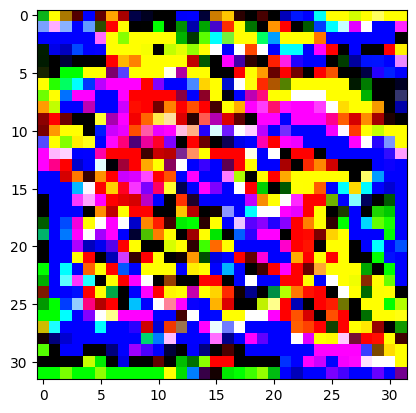

In [ ]:

import torch
import torch.nn as nn

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv

# Inline model initialization
net = nn.Sequential(
    # nn.PixelUnshuffle(2), nn.Conv2d(3 * 2**2, 4, 3, 1, padding=3//2),
    # nn.Conv2d(4, 3 * 2**2, 3, 1, padding=3//2), nn.PixelShuffle(2)
    # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, 4, 3, 1, padding=3//2), down=2),
    init_conv(nn.Conv2d(3, 3 * 2**2, 3, 1, padding=3//2), out_r=2), nn.PixelShuffle(2), # good
    # nn.PixelShuffle(2), init_conv(nn.Conv2d(3* 2**2, 3, 3, 1, padding=3//2), in_r=2),

    # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, 2* 2**2, 3, 1, padding=3//2), up=2, down=2), nn.PixelUnshuffle(2),
    # nn.PixelShuffle(2), init_conv(nn.Conv2d(2* 2**2, 3 * 2**2, 3, 1, padding=3//2), up=2, down=2), nn.PixelShuffle(2),

    nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, 3, 3, 1, padding=3//2), in_r=2), # good
    # init_conv(nn.Conv2d(3, 3, 3, 1, padding=3//2))
)
# self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * r**2, kernel_size, 1, padding=kernel_size//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
# self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch * r**2, out_ch, kernel_size, 1, padding=kernel_size//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]


# for n, p in net.named_parameters():
#     print(n, p)


dataiter = iter(train_loader) # get some random training images
images, labels = next(dataiter)
out = net(images[0])
# out = net(images[0].repeat_interleave(4, dim=0))

print(out.shape)
imshow(out.detach().cpu())



In [ ]:

# x = torch.rand(1,2,4,4)
# print(x)
# x = nn.PixelUnshuffle(2)(x)
# print(x) # [1,8,2,2]
# print(x.shape) # [1,2,4,4]
x = torch.rand(1,2,2,2).repeat(1,4,1,1)
print(x)
x = torch.rand(1,2,2,2).repeat_interleave(4,dim=1)
print(x)

# x = torch.rand(1,4,2,2)
# print(x)
# x = nn.PixelShuffle(2)(x)
# print(x)


tensor([[[[0.7029, 0.8369],
          [0.8177, 0.0125]],

         [[0.4732, 0.9710],
          [0.8584, 0.2046]],

         [[0.7029, 0.8369],
          [0.8177, 0.0125]],

         [[0.4732, 0.9710],
          [0.8584, 0.2046]],

         [[0.7029, 0.8369],
          [0.8177, 0.0125]],

         [[0.4732, 0.9710],
          [0.8584, 0.2046]],

         [[0.7029, 0.8369],
          [0.8177, 0.0125]],

         [[0.4732, 0.9710],
          [0.8584, 0.2046]]]])
tensor([[[[0.4048, 0.3870],
          [0.2477, 0.6194]],

         [[0.4048, 0.3870],
          [0.2477, 0.6194]],

         [[0.4048, 0.3870],
          [0.2477, 0.6194]],

         [[0.4048, 0.3870],
          [0.2477, 0.6194]],

         [[0.5305, 0.1096],
          [0.8902, 0.9634]],

         [[0.5305, 0.1096],
          [0.8902, 0.9634]],

         [[0.5305, 0.1096],
          [0.8902, 0.9634]],

         [[0.5305, 0.1096],
          [0.8902, 0.9634]]]])


In [ ]:
# @title ViT me
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SimpleViT(nn.Module):
    def __init__(self, in_dim, out_dim, dim, depth, heads, mlp_dim, channels=3, dim_head=8):
        super().__init__()

        self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
            # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # PixelShuffleConv(3, dim, 1, r=1/4),
            nn.PixelUnshuffle(2), nn.Conv2d(in_dim * 2**2, dim//2**2, 7, 1, padding=7//2), nn.PixelUnshuffle(2),
            )


        # dim = h/2^2 * w/2^2
        # self.pos_embedding = LearnedRoPE2D(dim)
        # self.pos_embedding = RoPE2D(dim)
        self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, dim), requires_grad=True) # positional_embedding == 'learnable'
        # nn.init.trunc_normal_(self.positional_emb, std=0.2)

        # self.dropout = nn.Dropout(p=0.1)
        self.transformer = AttentionBlock(d_model=dim, d_head=dim_head)
        # self.norm = nn.LayerNorm(dim)

        self.attention_pool = nn.Linear(dim, 1)
        self.out = nn.Linear(dim, out_dim, bias=False)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        # x = self.pos_embedding(x)
        x = x.flatten(-2).transpose(-2,-1) # b c h w -> b (h w) c
        x = x + self.positional_emb
        # x = self.dropout(x)

        x = self.transformer(x)
        # x = self.norm(x)

        # x = x.flatten(-2).mean(dim=-1) # meal pool
        attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
        x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]

        # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
        # x = torch.cat((cls_token, x), dim=1)
        # x = x[:, 0] # first token
        return self.out(x)


# pos_emb rope < learn < learned
# conv > pixel?
# droppath not required

dim = 64
dim_head = 8
heads = dim // dim_head
num_classes = 10
# model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
model = SimpleViT(in_dim=3, out_dim=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

# print(images.shape) # [batch, 3, 32, 32]
x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 3, 28,28, device=device)
logits = model(x)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")



NameError: name 'AttentionBlock' is not defined

In [ ]:
# @title lucidrains simple_vit.py
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/simple_vit.py
import torch
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = torch.arange(dim//4) / (dim//4 - 1)
    omega = 1.0 / (temperature ** omega)
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)
# pos_embedding = posemb_sincos_2d(h = image_height // patch_height, w = image_width // patch_width, dim = dim)
# x = x+pos_embedding

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim), nn.Linear(dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


def pair(t): return t if isinstance(t, tuple) else (t, t)
class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        patch_dim = channels * patch_height * patch_width
        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim), nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        self.pos_embedding = posemb_sincos_2d(h = image_height // patch_height, w = image_width // patch_width, dim = dim)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)
        self.to_latent = nn.Identity()
        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        device = img.device
        x = self.to_patch_embedding(img)
        x += self.pos_embedding.to(device, dtype=x.dtype)
        x = self.transformer(x)
        x = x.mean(dim = 1)
        x = self.to_latent(x)
        return self.linear_head(x)


# dim = 64
# dim_head = 8
# heads = dim // dim_head
# num_classes = 10
# # model = SimpleViT(image_size=32, patch_size=4, num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# model = SimpleViT(num_classes=num_classes, dim=dim, depth=1, heads=heads, mlp_dim=dim*4, channels = 3, dim_head = dim_head)
# optim = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [ ]:
# @title lucid CCT
# !pip install -q vit-pytorch

import torch
from vit_pytorch.cct import CCT
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CCT(
    img_size = (32,32),
    embedding_dim = 64,
    n_conv_layers = 1,
    kernel_size = 7,
    stride = 2,
    padding = 3,
    pooling_kernel_size = 3,
    pooling_stride = 2,
    # pooling_padding = 1,
    num_layers = 1,
    num_heads = 8,
    mlp_ratio = 1.,
    num_classes = 10,
    positional_embedding = 'learnable', # ['sine', 'learnable', 'none']
    dim_head = 8,
    # pool='mean', # ['mean', 'cls', 'max']
)


# def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):

optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 236235


x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 1, 28,28, device=device)
logits = model(x)
print(logits.shape)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

# loss: 1.057389  [49920/50000]
# Test Error:
#  Accuracy: 58.5%, Avg loss: 1.146490
# 8: loss: 0.801141  [49920/50000]
# Test Error:
#  Accuracy: 69.9%, Avg loss: 0.885053

# print(model)

# # cct 39371 learn
# loss: 1.426435  [49920/50000]
# Test Error:
#  Accuracy: 50.0%, Avg loss: 1.355331
# 5: loss: 0.954245  [49920/50000]
# Test Error:
#  Accuracy: 64.1%, Avg loss: 1.000242

39371
torch.Size([64, 10])


In [ ]:
# @title sincos_pos_embed
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import numpy as np

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): # grid_size: int of the grid height and width
    grid_h, grid_w = np.arange(grid_size, dtype=float), np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # prepend zeros for cls token later?
    return pos_embed # [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

import math
def interpolate_pos_encoding(x, pos_embed):
    npatch = x.shape[1] - 1
    N = pos_embed.shape[1] - 1
    if npatch == N: return pos_embed
    class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
    dim = x.shape[-1]
    pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
    pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


import torch
import torch.nn as nn
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size, self.patch_size = img_size, patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x): # [b,c,h,w]
        # B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

num_patches = 16
embed_dim = 8
# pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
pos_embed = torch.zeros(1, num_patches, embed_dim)
# patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
patch_embed = PatchEmbed()
# print(pos_embed)
# patch_embed.num_patches = (224/16)^2 = 14^2 = 196
# pos_embed = get_2d_sincos_pos_embed(pos_embed.shape[-1], int(patch_embed.num_patches**.5), cls_token=False)
pos_embed = get_2d_sincos_pos_embed(embed_dim, 14)
print(pos_embed)
print(pos_embed.shape) # 14^2, embed_dim

# x = torch.rand(4,224*224,embed_dim)
# pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

# pos_embed = interpolate_pos_encoding(x, pos_embed)
# print(pos_embed)

import matplotlib.pyplot as plt
plt.imshow(pos_embed)
plt.show()


In [ ]:
# @title posemb_sincos_2d
def posemb_sincos_2d(h, w, dim, temperature: int = 10000, dtype = torch.float32):
    print(h,w)
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    # print(y,x) # [h,w], y:row_num, x:col_num
    # assert (dim % 4) == 0, "feature dimension must be multiple of 4 for sincos emb"
    omega = 1. / (temperature**torch.linspace(0,1,dim//4))
    # print(omega)
    y = y.reshape(-1,1) * omega.unsqueeze(0) # [h*w,1]*[1,dim//4] = [h*w,dim//4]
    x = x.reshape(-1,1) * omega.unsqueeze(0)
    print(y.shape,x.shape) # [h,w], y:row num, x:col num
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1) # [h*w,dim]
    return pe.type(dtype)

# image_height, image_width = 64, 64
# patch_height, patch_width = 8, 8
h=3
w=5
dim=18
# pos_embedding = posemb_sincos_2d(h = image_height // patch_height, w = image_width // patch_width, dim = dim)
pos_embedding = posemb_sincos_2d(h=h, w=w, dim=dim)
# x = x+pos_embedding
# print(pos_embedding)
# print(pos_embedding.shape) # [h*w, dim]
# for i,x in enumerate(pos_embedding):
#     if i%h==0: print('### ', i, ' ###')
#     print(x)


In [ ]:
# @title data
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),) # do not normalise! want img in [0,1)
batch_size = 512 # 64 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x)

In [ ]:
# @title lucid CCT
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cct.py



In [ ]:
# @title lucidrains cct.py
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cct.py



def sinusoidal_embedding(n_channels, dim):
    pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                            for p in range(n_channels)])
    pe[:, 0::2] = torch.sin(pe[:, 0::2])
    pe[:, 1::2] = torch.cos(pe[:, 1::2])
    return rearrange(pe, '... -> 1 ...')

# modules

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()
        self.heads = num_heads
        head_dim = dim // self.heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(attention_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(projection_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        q = q * self.scale
        attn = einsum('b h i d, b h j d -> b h i j', q, k)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = einsum('b h i j, b h j d -> b h i d', attn, v)
        x = rearrange(x, 'b h n d -> b n (h d)')
        return self.proj_drop(self.proj(x))


class TransformerEncoderLayer(nn.Module):
    """
    Inspired by torch.nn.TransformerEncoderLayer and
    rwightman's timm package.
    """
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,attention_dropout=0.1, drop_path_rate=0.1):
        super().__init__()
        self.pre_norm = nn.LayerNorm(d_model)
        self.self_attn = Attention(dim=d_model, num_heads=nhead, attention_dropout=attention_dropout, projection_dropout=dropout)
        self.linear1  = nn.Linear(d_model, dim_feedforward)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1    = nn.LayerNorm(d_model)
        self.linear2  = nn.Linear(dim_feedforward, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.drop_path = DropPath(drop_path_rate)
        self.activation = F.gelu

    def forward(self, src, *args, **kwargs):
        src = src + self.drop_path(self.self_attn(self.pre_norm(src)))
        src = self.norm1(src)
        src2 = self.linear2(self.dropout1(self.activation(self.linear1(src))))
        src = src + self.drop_path(self.dropout2(src2))
        return src

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        batch, drop_prob, device, dtype = x.shape[0], self.drop_prob, x.device, x.dtype

        if drop_prob <= 0. or not self.training:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (batch, *((1,) * (x.ndim - 1)))

        keep_mask = torch.zeros(shape, device = device).float().uniform_(0, 1) < keep_prob
        output = x.div(keep_prob) * keep_mask.float()
        return output


class Tokenizer(nn.Module):
    def __init__(self, kernel_size, stride, padding, pooling_kernel_size=3, pooling_stride=2, pooling_padding=1, n_conv_layers=1,
                 n_input_channels=3, n_output_channels=64, in_planes=64,
                 activation=None, max_pool=True, conv_bias=False):
        super().__init__()
        n_filter_list = [n_input_channels] + [in_planes for _ in range(n_conv_layers - 1)] + [n_output_channels]
        n_filter_list_pairs = zip(n_filter_list[:-1], n_filter_list[1:])
        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(chan_in, chan_out, kernel_size=(kernel_size, kernel_size), stride=(stride, stride), padding=(padding, padding), bias=conv_bias),
                nn.Identity() if not exists(activation) else activation(),
                nn.MaxPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride, padding=pooling_padding) if max_pool else nn.Identity())
                for chan_in, chan_out in n_filter_list_pairs
            ])
        self.apply(self.init_weight)

    def sequence_length(self, n_channels=3, height=224, width=224):
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        return rearrange(self.conv_layers(x), 'b c h w -> b (h w) c')

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

class Tokenizer(nn.Module):
    def __init__(self, n_conv_layers=1, n_input_channels=3, n_output_channels=64, in_planes=64,):
        super().__init__()
        n_filter_list = [n_input_channels] + [in_planes for _ in range(n_conv_layers - 1)] + [n_output_channels]
        # print(n_filter_list)
        n_filter_list_pairs = zip(n_filter_list[:-1], n_filter_list[1:])
        # print([x for x in n_filter_list_pairs])
        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(chan_in, chan_out, kernel_size=7, stride=2, padding=7//2, bias=False),
                # nn.Identity() if not exists(activation) else activation(), # None
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                ) for chan_in, chan_out in n_filter_list_pairs
            ])

    # def sequence_length(self, n_channels=3, height=224, width=224):
    #     return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        # return rearrange(self.conv_layers(x), 'b c h w -> b (h w) c')
        return self.conv_layers(x)

class TransformerClassifier(nn.Module):
    def __init__(self,
                 seq_pool=True,
                 embedding_dim=768,
                 num_layers=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 dropout_rate=0.1,
                 attention_dropout=0.1,
                 stochastic_depth_rate=0.1,
                 positional_embedding='sine',
                 sequence_length=None,
                 *args, **kwargs):
        super().__init__()
        assert positional_embedding in {'sine', 'learnable', 'none'}

        dim_feedforward = int(embedding_dim * mlp_ratio)
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.seq_pool = seq_pool

        assert exists(sequence_length) or positional_embedding == 'none', \
            f"Positional embedding is set to {positional_embedding} and" \
            f" the sequence length was not specified."
        if not seq_pool:
            sequence_length += 1
            self.class_emb = nn.Parameter(torch.zeros(1, 1, self.embedding_dim), requires_grad=True)
        else:
            self.attention_pool = nn.Linear(self.embedding_dim, 1)
        if positional_embedding == 'none':
            self.positional_emb = None
        elif positional_embedding == 'learnable':
            self.positional_emb = nn.Parameter(torch.zeros(1, sequence_length, embedding_dim),
                                               requires_grad=True)
            nn.init.trunc_normal_(self.positional_emb, std=0.2)
        else:
            self.positional_emb = nn.Parameter(sinusoidal_embedding(sequence_length, embedding_dim),
                                               requires_grad=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        dpr = [x.item() for x in torch.linspace(0, stochastic_depth_rate, num_layers)]
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                    dim_feedforward=dim_feedforward, dropout=dropout_rate,
                                    attention_dropout=attention_dropout, drop_path_rate=layer_dpr)
            for layer_dpr in dpr])
        self.norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.apply(self.init_weight)

    def forward(self, x):
        b = x.shape[0]
        if not exists(self.positional_emb) and x.size(1) < self.sequence_length:
            x = F.pad(x, (0, 0, 0, self.n_channels - x.size(1)), mode='constant', value=0)
        if not self.seq_pool:
            cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
            x = torch.cat((cls_token, x), dim=1)
        if exists(self.positional_emb):
            x += self.positional_emb
        x = self.dropout(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        if self.seq_pool:
            attn_weights = rearrange(self.attention_pool(x), 'b n 1 -> b n')
            x = einsum('b n, b n d -> b d', attn_weights.softmax(dim = 1), x)
        else:
            x = x[:, 0]
        return self.fc(x)

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and exists(m.bias):
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)




In [ ]:
# @title lucidrains vit.py
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
import torch
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim), nn.Linear(dim, hidden_dim), nn.GELU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim), nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)


In [ ]:
# @title 2D RoPE
# https://github.com/naver-ai/rope-vit/blob/main/models/vit_rope.py


# https://github.com/facebookresearch/deit
# https://github.com/meta-llama/codellama/blob/main/llama/model.py

import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
# from timm.models.vision_transformer import Mlp, PatchEmbed , _cfg
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from deit.models_v2 import vit_models, Layer_scale_init_Block, Attention

def init_random_2d_freqs(dim: int, num_heads: int, theta: float = 10.0, rotate: bool = True):
    freqs_x = []
    freqs_y = []
    mag = 1 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    for i in range(num_heads):
        angles = torch.rand(1) * 2 * torch.pi if rotate else torch.zeros(1)
        fx = torch.cat([mag * torch.cos(angles), mag * torch.cos(torch.pi/2 + angles)], dim=-1)
        fy = torch.cat([mag * torch.sin(angles), mag * torch.sin(torch.pi/2 + angles)], dim=-1)
        freqs_x.append(fx)
        freqs_y.append(fy)
    freqs_x = torch.stack(freqs_x, dim=0)
    freqs_y = torch.stack(freqs_y, dim=0)
    freqs = torch.stack([freqs_x, freqs_y], dim=0)
    return freqs

def compute_mixed_cis(freqs: torch.Tensor, t_x: torch.Tensor, t_y: torch.Tensor, num_heads: int):
    N = t_x.shape[0]
    depth = freqs.shape[1]
    # No float 16 for this range
    with torch.cuda.amp.autocast(enabled=False):
        freqs_x = (t_x.unsqueeze(-1) @ freqs[0].unsqueeze(-2)).view(depth, N, num_heads, -1).permute(0, 2, 1, 3)
        freqs_y = (t_y.unsqueeze(-1) @ freqs[1].unsqueeze(-2)).view(depth, N, num_heads, -1).permute(0, 2, 1, 3)
        freqs_cis = torch.polar(torch.ones_like(freqs_x), freqs_x + freqs_y)
    return freqs_cis


def compute_axial_cis(dim: int, end_x: int, end_y: int, theta: float = 100.0):
    freqs_x = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))
    freqs_y = 1.0 / (theta ** (torch.arange(0, dim, 4)[: (dim // 4)].float() / dim))

    t_x, t_y = init_t_xy(end_x, end_y)
    freqs_x = torch.outer(t_x, freqs_x)
    freqs_y = torch.outer(t_y, freqs_y)
    freqs_cis_x = torch.polar(torch.ones_like(freqs_x), freqs_x)
    freqs_cis_y = torch.polar(torch.ones_like(freqs_y), freqs_y)
    return torch.cat([freqs_cis_x, freqs_cis_y], dim=-1)

def init_t_xy(end_x: int, end_y: int):
    t = torch.arange(end_x * end_y, dtype=torch.float32)
    t_x = (t % end_x).float()
    t_y = torch.div(t, end_x, rounding_mode='floor').float()
    return t_x, t_y


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    if freqs_cis.shape == (x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-2 else 1 for i, d in enumerate(x.shape)]
    elif freqs_cis.shape == (x.shape[-3], x.shape[-2], x.shape[-1]):
        shape = [d if i >= ndim-3 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq).to(xq.device), xk_out.type_as(xk).to(xk.device)


class RoPEAttention(Attention):
    """Multi-head Attention block with rotary position embeddings."""
    def forward(self, x, freqs_cis):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q[:, :, 1:], k[:, :, 1:] = apply_rotary_emb(q[:, :, 1:], k[:, :, 1:], freqs_cis=freqs_cis)
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class RoPE_Layer_scale_init_Block(Layer_scale_init_Block):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    # with slight modifications
    def __init__(self, *args, **kwargs):
        kwargs["Attention_block"] = RoPEAttention
        super().__init__(*args, **kwargs)

    def forward(self, x, freqs_cis):
        x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), freqs_cis=freqs_cis))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

class rope_vit_models(vit_models):
    def __init__(self, rope_theta=100.0, rope_mixed=False, use_ape=False, **kwargs):
        super().__init__(**kwargs)
        img_size = kwargs['img_size'] if 'img_size' in kwargs else 224
        patch_size = kwargs['patch_size'] if 'patch_size' in kwargs else 16
        num_heads = kwargs['num_heads'] if 'num_heads' in kwargs else 12
        embed_dim = kwargs['embed_dim'] if 'embed_dim' in kwargs else 768
        mlp_ratio = kwargs['mlp_ratio'] if 'mlp_ratio' in kwargs else 4.

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        trunc_normal_(self.cls_token, std=.02)

        self.use_ape = use_ape
        if not self.use_ape:
            self.pos_embed = None

        self.rope_mixed = rope_mixed
        self.num_heads = num_heads
        self.patch_size = patch_size

        if self.rope_mixed:
            self.compute_cis = partial(compute_mixed_cis, num_heads=self.num_heads)

            freqs = []
            for i, _ in enumerate(self.blocks):
                freqs.append(
                    init_random_2d_freqs(dim=embed_dim // num_heads, num_heads=num_heads, theta=rope_theta)
                )
            freqs = torch.stack(freqs, dim=1).view(2, len(self.blocks), -1)
            self.freqs = nn.Parameter(freqs.clone(), requires_grad=True)

            t_x, t_y = init_t_xy(end_x = img_size // patch_size, end_y = img_size // patch_size)
            self.register_buffer('freqs_t_x', t_x)
            self.register_buffer('freqs_t_y', t_y)
        else:
            self.compute_cis = partial(compute_axial_cis, dim=embed_dim//num_heads, theta=rope_theta)

            freqs_cis = self.compute_cis(end_x = img_size // patch_size, end_y = img_size // patch_size)
            self.freqs_cis = freqs_cis

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'freqs'}

    def forward_features(self, x):
        B, C, H, W = x.shape
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        if self.use_ape:
            pos_embed = self.pos_embed
            if pos_embed.shape[-2] != x.shape[-2]:
                img_size = self.patch_embed.img_size
                patch_size = self.patch_embed.patch_size
                pos_embed = pos_embed.view(
                    1, (img_size[1] // patch_size[1]), (img_size[0] // patch_size[0]), self.embed_dim
                ).permute(0, 3, 1, 2)
                pos_embed = F.interpolate(
                    pos_embed, size=(H // patch_size[1], W // patch_size[0]), mode='bicubic', align_corners=False
                )
                pos_embed = pos_embed.permute(0, 2, 3, 1).flatten(1, 2)
            x = x + pos_embed

        x = torch.cat((cls_tokens, x), dim=1)

        if self.rope_mixed:
            if self.freqs_t_x.shape[0] != x.shape[1] - 1:
                t_x, t_y = init_t_xy(end_x = W // self.patch_size, end_y = H // self.patch_size)
                t_x, t_y = t_x.to(x.device), t_y.to(x.device)
            else:
                t_x, t_y = self.freqs_t_x, self.freqs_t_y
            freqs_cis = self.compute_cis(self.freqs, t_x, t_y)

            for i , blk in enumerate(self.blocks):
                x = blk(x, freqs_cis=freqs_cis[i])
        else:
            if self.freqs_cis.shape[0] != x.shape[1] - 1:
                freqs_cis = self.compute_cis(end_x = W // self.patch_size, end_y = H // self.patch_size)
            else:
                freqs_cis = self.freqs_cis
            freqs_cis = freqs_cis.to(x.device)

            for i , blk in enumerate(self.blocks):
                x = blk(x, freqs_cis=freqs_cis)

        x = self.norm(x)
        x = x[:, 0]

        return x


def adjust_pos_embed_size(model, state_dict):
    # interpolate position embedding
    if 'pos_embed' in state_dict:
        pos_embed_checkpoint = state_dict['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
        # only the position tokens are interpolated
        pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
        pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
        pos_tokens = torch.nn.functional.interpolate(
            pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
        pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
        new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
        state_dict['pos_embed'] = new_pos_embed

    return state_dict

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


ModuleNotFoundError: No module named 'deit'

In [ ]:
# @title facebookresearch ViT down
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
import numpy as np
import torch
import torch.nn as nn
from src.utils.tensors import trunc_normal_, repeat_interleave_batch

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (pred_emb_dim//2, 1,h,h) ->
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): # grid_size: int of the grid height and width
    grid_h, grid_w = np.arange(grid_size, dtype=float), np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid) # (pred_emb_dim, [2,1,h,h])
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # prepend zeros for cls token later?
    return pos_embed # [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training: return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Block(nn.Module):
    def __init__(self, dim, num_heads, drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        # self.attn = Attention(dim, num_heads=num_heads, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=drop)
        self.attn = AttentionBlock(dim, dim//num_heads)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * 4)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention: return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size, self.patch_size = img_size, patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x): # [b,c,h,w]
        # B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        stem = []
        channels = [in_chans] + channels
        act = nn.ReLU(inplace=True)
        for i in range(len(channels) - 2):
            # stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            # if batch_norm:
            #     stem += [nn.BatchNorm2d(channels[i+1])]
            # stem += [nn.ReLU(inplace=True)]
            # nn.Sequential(
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm)), nn.BatchNorm2d(channels[i+1]) if batch_norm else nn.Identity(), act,]
            # )
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)

class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False) # [1, (h*w), pred_emb_dim]
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False) # get_2d_sincos_pos_embed(pred_emb_dim, (h)) ->
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x]
        if not isinstance(masks, list): masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x) # batch*M // M

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x) # apply pos emb to mask tokens

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)
        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model




In [ ]:
# @title facebookresearch ViT base
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py

# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import math
import numpy as np
import torch
import torch.nn as nn
from src.utils.tensors import trunc_normal_, repeat_interleave_batch
from src.masks.utils import apply_masks

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False): # grid_size: int of the grid height and width
    grid_h, grid_w = np.arange(grid_size, dtype=float), np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)
    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0) # prepend zeros for cls token later?
    return pos_embed # [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
# lin act drop lin drop


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None,
        drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([
            Block(dim=predictor_embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.predictor_norm = norm_layer(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        self.init_std = init_std
        trunc_normal_(self.mask_token, std=self.init_std)
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.predictor_blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'

        if not isinstance(masks_x, list): masks_x = [masks_x]
        if not isinstance(masks, list): masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # ------
        self.init_std = init_std
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)
        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N:
            return pos_embed
        class_emb = pos_embed[:, 0]
        pos_embed = pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(
            pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=math.sqrt(npatch / N),
            mode='bicubic',
        )
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


from functools import partial
def vit_predictor(**kwargs):
    model = VisionTransformerPredictor(
        mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model




In [ ]:
# @title lucid SimpleViT
import torch
from vit_pytorch import SimpleViT

model = SimpleViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 10,
    dim = 64,
    depth = 1,
    heads = 8,
    mlp_dim = 64,

    # num_heads = 8,
    # mlp_ratio = 1.,
    # positional_embedding = 'learnable', # ['sine', 'learnable', 'none']
    dim_head = 8,

)
# def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):

# img = torch.randn(1, 3, 256, 256)
# preds = v(img) # (1, 1000)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 236235
x = torch.rand(64, 3, 32, 32, device=device)
# x = torch.rand(64, 1, 28,28, device=device)
logits = model(x)
print(logits.shape)

# loss: 1.684826  [49920/50000]
# Test Error:
#  Accuracy: 40.7%, Avg loss: 1.642769


38602
torch.Size([64, 10])


In [ ]:
# @title NVlabs afno2d.py
# https://github.com/NVlabs/AFNO-transformer/blob/master/afno/afno2d.py
# Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

# import math
import torch
# import torch.fft
import torch.nn as nn
import torch.nn.functional as F

class AFNO2D(nn.Module):
    """
    hidden_size: channel dimension size
    num_blocks: how many blocks to use in the block diagonal weight matrices (higher => less complexity but less parameters)
    hard_thresholding_fraction: how many frequencies you want to completely mask out (lower => hard_thresholding_fraction^2 less FLOPs)
    """
    def __init__(self, hidden_size, num_blocks=8, hard_thresholding_fraction=1, hidden_size_factor=1):
        super().__init__()
        assert hidden_size % num_blocks == 0, f"hidden_size {hidden_size} should be divisble by num_blocks {num_blocks}"

        self.hidden_size = hidden_size
        self.num_blocks = num_blocks
        self.block_size = self.hidden_size // self.num_blocks
        self.hard_thresholding_fraction = hard_thresholding_fraction
        self.hidden_size_factor = hidden_size_factor
        self.scale = 0.02

        self.w1 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size, self.block_size * self.hidden_size_factor))
        self.b1 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size * self.hidden_size_factor))
        self.w2 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size * self.hidden_size_factor, self.block_size))
        self.b2 = nn.Parameter(self.scale * torch.randn(2, self.num_blocks, self.block_size))

    def forward(self, x, spatial_size=None):
        bias = x
        dtype = x.dtype
        x = x.float()
        B, N, C = x.shape

        x = x.reshape(B, H, W, C)
        x = torch.fft.rfft2(x, dim=(1, 2), norm="ortho")
        x = x.reshape(B, x.shape[1], x.shape[2], self.num_blocks, self.block_size) # [b, h, w//2+1, n_blocks, block_size]
        o1_real = torch.zeros([B, x.shape[1], x.shape[2], self.num_blocks, self.block_size * self.hidden_size_factor], device=x.device)
        o1_imag = torch.zeros([B, x.shape[1], x.shape[2], self.num_blocks, self.block_size * self.hidden_size_factor], device=x.device)
        o2_real = torch.zeros(x.shape, device=x.device)
        o2_imag = torch.zeros(x.shape, device=x.device)

        total_modes = N // 2 + 1
        kept_modes = int(total_modes * self.hard_thresholding_fraction)

        o1_real[:, :, :kept_modes] = F.relu(
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].real, self.w1[0]) - \
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].imag, self.w1[1]) + \
            self.b1[0]
        )

        o1_imag[:, :, :kept_modes] = F.relu(
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].imag, self.w1[0]) + \
            torch.einsum('...bi,bio->...bo', x[:, :, :kept_modes].real, self.w1[1]) + \
            self.b1[1]
        )

        o2_real[:, :, :kept_modes] = (
            torch.einsum('...bi,bio->...bo', o1_real[:, :, :kept_modes], self.w2[0]) - \
            torch.einsum('...bi,bio->...bo', o1_imag[:, :, :kept_modes], self.w2[1]) + \
            self.b2[0]
        )

        o2_imag[:, :, :kept_modes] = (
            torch.einsum('...bi,bio->...bo', o1_imag[:, :, :kept_modes], self.w2[0]) + \
            torch.einsum('...bi,bio->...bo', o1_real[:, :, :kept_modes], self.w2[1]) + \
            self.b2[1]
        )

        x = torch.stack([o2_real, o2_imag], dim=-1)
        x = F.softshrink(x, lambd=0.01)
        x = torch.view_as_complex(x)
        x = x.reshape(B, x.shape[1], x.shape[2], C)
        x = torch.fft.irfft2(x, s=(H, W), dim=(1, 2), norm="ortho")
        x = x.reshape(B, N, C)
        x = x.type(dtype)
        return x + bias

b,c,h,w = 2,16,9,9
# w//2+1
# b,c,h,w = 2,3,16,16
mix = AFNO2D(c)
x = torch.rand(b,c,h,w)
out = mix(x)
print(out.shape)
# print(out)



In [ ]:
# @title AFNO2D_channelfirst save
# Adaptive Frequency Filters As Efficient Global Token Mixers
# https://arxiv.org/pdf/2307.14008
# https://github.com/microsoft/TokenMixers/blob/main/Adaptive%20Frequency%20Filters/affnet/modules/aff_block.py#L62
import torch
import torch.nn as nn
import torch.nn.functional as F

class AFNO2D_channelfirst(nn.Module):
    def __init__(self, hidden_size, num_blocks=8, hidden_size_factor=1):
        super().__init__()
        self.num_blocks = num_blocks # num_blocks: how many blocks to use in the block diagonal weight matrices (higher => less complexity but less parameters)
        self.block_size = hidden_size // self.num_blocks
        scale = 0.02

        self.w1 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size, self.block_size * hidden_size_factor))
        self.b1 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size * hidden_size_factor))
        self.w2 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size * hidden_size_factor, self.block_size))
        self.b2 = nn.Parameter(scale * torch.randn(2, self.num_blocks, self.block_size))

    @torch.cuda.amp.autocast(enabled=False)
    def forward(self, x): # [b,c,h,w]
        bias = x
        dtype = x.dtype
        x = x.float()
        B, C, H, W = x.shape
        x = torch.fft.rfft2(x, dim=(2, 3), norm="ortho") # [b, c, h, w//2+1]
        origin_ffted = x
        x = x.unflatten(1, (self.num_blocks, self.block_size)) # [b, n_blocks, block_size, h, w//2+1]

# [b, n_blocks, block_size, h, w//2+1] @ [n_blocks, block_size, block_size * h_factor] -> [b, n_blocks, block_size * h_factor, h, w//2+1]
# + [n_blocks, block_size * h_factor]
        o1_real = F.relu(torch.einsum('bkihw,kio->bkohw', x.real, self.w1[0]) - \
            torch.einsum('bkihw,kio->bkohw', x.imag, self.w1[1]) + self.b1[0, :, :, None, None])
        o1_imag = F.relu(torch.einsum('bkihw,kio->bkohw', x.imag, self.w1[0]) + \
            torch.einsum('bkihw,kio->bkohw', x.real, self.w1[1]) + self.b1[1, :, :, None, None])
        o2_real = (torch.einsum('bkihw,kio->bkohw', o1_real, self.w2[0]) - \
            torch.einsum('bkihw,kio->bkohw', o1_imag, self.w2[1]) + self.b2[0, :, :, None, None])
        o2_imag = (torch.einsum('bkihw,kio->bkohw', o1_imag, self.w2[0]) + \
            torch.einsum('bkihw,kio->bkohw', o1_real, self.w2[1]) + self.b2[1, :, :, None, None])

# [n_blocks, block_size * h_factor, block_size]


        x = torch.stack([o2_real, o2_imag], dim=-1)
        x = F.softshrink(x, lambd=0.01)
        x = torch.view_as_complex(x)
        x = x.flatten(1,2) # [b, c, h, w]

        x = x * origin_ffted
        x = torch.fft.irfft2(x, s=(H, W), dim=(2, 3), norm="ortho")
        x = x.type(dtype)
        return x + bias

# batch, T, dim = 2,7,5
b,c,h,w = 2,16,9,9
# w//2+1
# b,c,h,w = 2,3,16,16
mix = AFNO2D_channelfirst(c, 4)
x = torch.rand(b,c,h,w)
out = mix(x)
print(out.shape)
# print(out)


torch.Size([2, 16, 9, 5])
torch.Size([2, 4, 4, 9, 5])
torch.Size([2, 16, 9, 9])


<ipython-input-36-6b5c42229079>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
